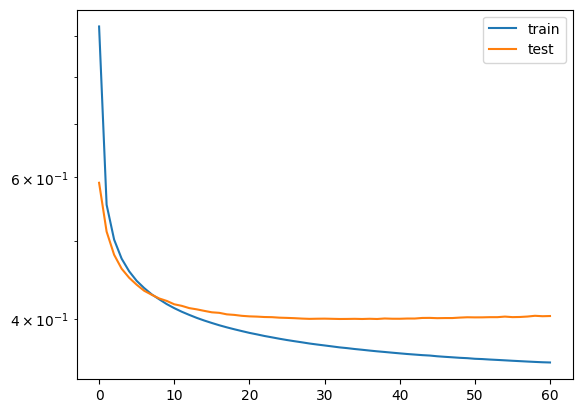

lowest test at epoch 35 with loss 0.39949986046077285


In [50]:
import matplotlib.pyplot as plt, json
import pathlib

json_file = "../saved_models/model_preCondRNN_v4.2/losses.json"
pathlib.Path(json_file).parent.mkdir(parents=True, exist_ok=True)

log = json.load(open(json_file))

train_losses = [l["ce_train"] for l in log]
test_losses = [l["ce_test"] for l in log]

plt.plot(train_losses, label='train')
plt.plot(test_losses,  label='test')
plt.yscale('log'); plt.legend(); plt.show()

print(f"lowest test at epoch {test_losses.index(min(test_losses))} with loss {min(test_losses)}")


## Loading Best model

In [36]:
from visualize_latent_space import load_model_from_folder
import torch

folder = "../saved_models/model_preCondRNN_v4.2"
model, vocab, train_args = load_model_from_folder(folder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Loading vocabulary from ../saved_models/model_preCondRNN_v4.2/vocab.pkl …


ConditionalAutoencoder(
  (embedding): Embedding(36, 256)
  (encoder_rnn): LSTM(261, 512, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (to_latent): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=200, bias=True)
  )
  (latent_to_decoder_hidden): Linear(in_features=200, out_features=1536, bias=True)
  (decoder_rnn): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.1)
  (output_to_vocab): Linear(in_features=512, out_features=36, bias=True)
  (property_predictor): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)

## Loading test_loader

In [37]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

# ---
from utils.data_utils import load_preprocessed_data, SmilesDataset


prop_file = os.path.join("..", train_args.prop_file)
max_seq_length = train_args.max_seq_length
training_percent = train_args.training_percent
batch_size = train_args.batch_size
seed = train_args.seed


# --- Load data from SMILES+properties file ---
processed_data = load_preprocessed_data(prop_file, max_seq_length=max_seq_length)
pytorch_dataset = SmilesDataset(processed_data)



# split the dataset into train and test sets
num_total = len(pytorch_dataset)
num_train = int(num_total * training_percent)

train_dataset, test_dataset = train_test_split(
    pytorch_dataset, train_size=num_train, shuffle=True, random_state=seed
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)


📖  Caricamento dati da: smiles_preprocessed_scale-zscore.csv
    -> Trovate 500004 molecole valide.
    -> Creato vocabolario con 36 caratteri.


In [38]:
from sklearn.metrics import r2_score
Z, y_true, y_pred = [], [], []
for data in test_loader:
    with torch.no_grad():
        z, _, c_hat = model(data["input"].to(device),
                            data["properties"].to(device),
                            data["length"].to(device))
    y_true.append(data["properties"])
    y_pred.append(c_hat.cpu())
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()
print("R2 per colonna:", r2_score(y_true, y_pred, multioutput='raw_values'))

R2 per colonna: [0.9981755  0.9977068  0.99896985 0.9956312  0.99669164]


In [39]:
# load mol from mol_test.csv
from pathlib import Path
import json
# ---
from visualize_latent_space import load_smiles_from_csv, smiles_dict_to_tensor

molecules_df = load_smiles_from_csv("../assets/mol_test.csv")
x, c, l, logp_vals, valid_smiles, names, paper_vals = smiles_dict_to_tensor(molecules_df, vocab, train_args.max_seq_length)
x, c, l = x.to(device), c.to(device), l.to(device)
smiles_scale_file = "../dataset/ZINC_with_drugs/smiles_preprocessed_scale-zscore_scaling_metrics.json"

    # load dataset scale metric from json file
scale_file = Path(smiles_scale_file)
if scale_file.exists():
    with open(scale_file) as f:
        scale_data = json.load(f)
        print(f"[INFO] Loaded scaling metrics from {scale_file.as_posix()}")
        if scale_data["Scaling method"] == "zscore":
            scale_metrics = scale_data['Scale metrics']
            mean = torch.tensor(scale_metrics[0], device=device, dtype=torch.float32)
            std = torch.tensor(scale_metrics[1], device=device, dtype=torch.float32)
            c = (c - mean) / std
            
with torch.no_grad():
    latent = model(x, c, l)[0].cpu().numpy()
    print(f"[INFO] Encoded {latent.shape[0]} molecules → latent_dim={latent.shape[1]}")
    

[INFO] Loaded scaling metrics from ../dataset/ZINC_with_drugs/smiles_preprocessed_scale-zscore_scaling_metrics.json
[INFO] Encoded 32 molecules → latent_dim=200


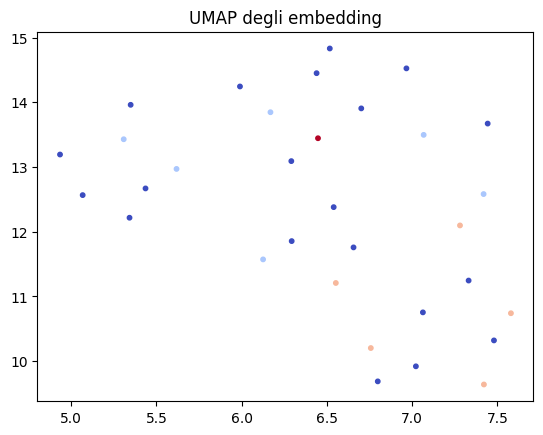

In [42]:
import umap, matplotlib.pyplot as plt
Z = latent      # (N, d)
labels = paper_vals 
Z2 = umap.UMAP(metric='cosine').fit_transform(Z)
plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=10, cmap='coolwarm')
plt.title('UMAP degli embedding')
plt.show()

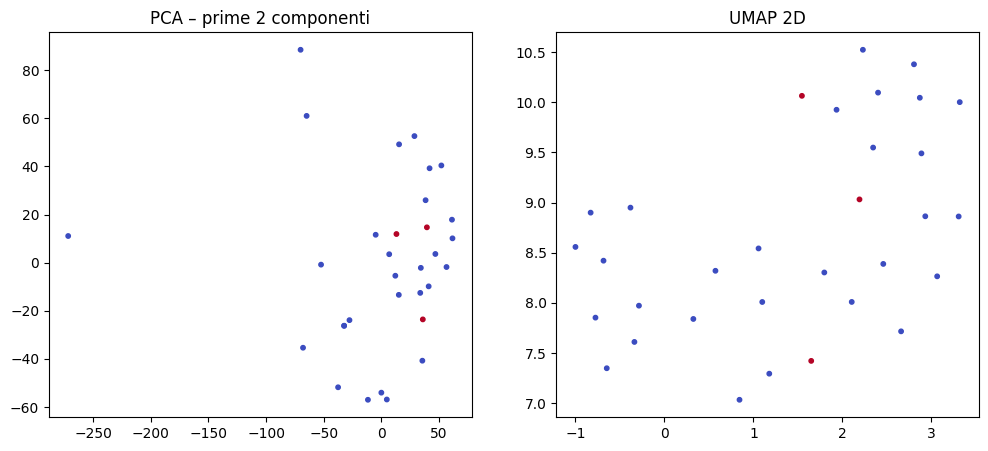

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt


labels = [1 if "POLY" in name else 0 for name in names]
Z_pca = PCA(n_components=3).fit_transform(Z)
Z_umap = umap.UMAP(n_components=2, metric='cosine').fit_transform(Z)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(Z_pca[:,0], Z_pca[:,1], c=labels, s=10, cmap='coolwarm')
ax[0].set_title('PCA – prime 2 componenti')

ax[1].scatter(Z_umap[:,0], Z_umap[:,1], c=labels, s=10, cmap='coolwarm')
ax[1].set_title('UMAP 2D')
plt.show()

In [9]:
# Correlazione dimensione-proprietà

import pandas as pd
import seaborn as sns

df = pd.DataFrame(Z, columns=[f'z{i}' for i in range(Z.shape[1])])
df['logP'] = logp_vals         # proprietà note
corr = df.corr()['logP'].abs().sort_values(ascending=False)[:10]
print(corr)

# Dimensioni con |ρ| alto mostrano disentanglement; puoi regolare β-VAE o FiLM se vedi che l’informazione si disperde.

logP    1.000000
z42     0.488810
z125    0.469683
z18     0.430627
z51     0.427086
z174    0.424781
z95     0.411214
z2      0.402896
z45     0.396140
z107    0.394211
Name: logP, dtype: float64


In [10]:
from rdkit import Chem
def is_valid(smi): return Chem.MolFromSmiles(smi) is not None

N = 1000
valid, uniq = 0, set()
print(vocab)
start_token = "X"
eos_idx = "E"

def detokenize(token_indices):
    # token_indices: list or tensor of token indices
    # Convert indices to tokens using vocab (reverse mapping)
    idx_to_token = {v: k for k, v in vocab.items()}
    if hasattr(token_indices, 'tolist'):
        token_indices = token_indices.tolist()
    tokens = [idx_to_token[idx] for idx in token_indices if idx in idx_to_token]
    # Remove start_token and everything after eos_idx
    if start_token in tokens:
        tokens = tokens[tokens.index(start_token)+1:]
    if eos_idx in tokens:
        tokens = tokens[:tokens.index(eos_idx)]
    return ''.join(tokens)

for _ in range(N):
    z = torch.randn(1, model.latent_size).to(device)
    c = torch.zeros(1, model.num_prop).to(device)       
    toks = model.sample(z, c, start_token, eos_idx, top_k=50, temperature=0.8)
    smi  = detokenize(toks[0])
    if is_valid(smi): valid += 1
    uniq.add(smi)
print(f"Validity {valid/N:.3f},  Uniqueness {len(uniq)/valid if valid else 0:.3f}")

{'_': 0, 'X': 1, 'E': 2, '#': 3, '(': 4, ')': 5, '+': 6, '-': 7, '/': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '=': 16, '@': 17, 'B': 18, 'C': 19, 'F': 20, 'H': 21, 'I': 22, 'N': 23, 'O': 24, 'P': 25, 'S': 26, '[': 27, '\\': 28, ']': 29, 'c': 30, 'l': 31, 'n': 32, 'o': 33, 'r': 34, 's': 35}


AttributeError: 'str' object has no attribute 'to'

In [44]:
import numpy as np, sklearn                        # (N, d)
props = c.cpu().numpy()              
print(props.shape)# (N, 5)
for j, name in enumerate(["ExactMW", "LogP", "NumHBD", "NumHBA", "TPSA"]):
    r2 = sklearn.linear_model.LinearRegression().fit(Z, props[:,j]).score(Z, props[:,j])
    print(name, r2)
    

    
# Se vedi R² > 0.9 per (quasi) tutti i j significa che z ≈ funzione lineare delle proprietà → povera di informazione strutturale.

(32, 5)
ExactMW 1.0
LogP 1.0
NumHBD 1.0
NumHBA 1.0
TPSA 1.0


In [45]:
import numpy as np, torch, pandas as pd, rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr

########################
# 1. Input
########################
smiles_list = valid_smiles        # list/array of SMILES  (N,)

# tensor/ndarray of shape (N, latent_dim)

########################
# 2. Fingerprints
########################
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048)
       for smi in smiles_list]

# 3. Calcolo similarità con BulkTanimotoSimilarity
import numpy as np
N = len(fps)  # numero di molecole
tan = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])  # fps[:i] è una lista
    tan[i, :i] = sims
    tan[:i, i] = sims  # simmetria
    
########################
# 3. Latent distances
########################
Z_np = np.asarray(Z, dtype=np.float32)
d_lat = pairwise_distances(Z_np, metric="cosine")   # (N,N)

########################
# 4. Spearman ρ
########################
# vector-ise upper-triangular part
triu = np.triu_indices(N, k=1)
rho, p = spearmanr(1 - tan[triu], d_lat[triu])      # 1-tan = distance

print(f"Spearman ρ = {rho:.3f}  (p = {p:.2e})")

Spearman ρ = 0.408  (p = 2.53e-21)


[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerator
[18:59:12] DEPRECATION WARNING: please use MorganGenerat

In [48]:
# vettore delle proprietà normalizzate di POLYMER 2
c_poly = torch.tensor(c[-1]).unsqueeze(0).to(device)  
l_poly = torch.tensor(l[-1]).unsqueeze(0).to(device)  
x_poly = x[-1].unsqueeze(0).to(device)  # shape (1, L)

c_zero = torch.zeros_like(c)  # (1, num_prop)

# ==> per tutte le piccole molecole passa SEMPRE c_poly
Z_poly, Z_mols = [], []
with torch.no_grad():
    Z_poly = model(x_poly, c_poly,l_poly)[0]     # (1,d)
    latent = model(x, c_poly.repeat(x.shape[0], 1), l)[0]
                                          # (N,d)

print(Z_poly.shape, latent.shape)

d_new = torch.cdist(Z_poly.cpu(), latent.cpu()).squeeze(0).numpy()
zzz = zip(d_new, names)
d_new_, names_ = zip(*sorted(zzz, key=lambda x: x[0]))
for i in range(len(d_new_)):
    print(f"{d_new_[i]:.3f} {names_[i]}")

torch.Size([1, 200]) torch.Size([32, 200])
0.000 POLYMER 0
0.354 POLYMER 3
0.433 Phthalic_acid
1.000 POLYMER precrop
1.042 Chrysene
1.135 Nimesulide
1.559 sertralina
1.630 Aspirin
1.644 fluoxetina
1.654 paracetamolo
1.721 Metoclopramide
1.737 2-4-5-trichlorophenoxyacetic acid
1.896 Diclofenac
1.904 amoxicillina
1.912 Heteroatoms
1.912 carbamazepina
1.916 Ibuprofen
1.941 Dimethylurea
1.961 Etoricoxib
1.992 Indomethacin
2.004 Pyramidone
2.056 ciprofloxacina
2.108 Oestradiol
2.301 polistirene
4.793 urea
8.342 Benzene
10.364 Cyclohexane
11.866 Acetic acid
11.866 acido acetico
16.146 PVC
47.740 Ethanol
185.144 Polietilene


/tmp/ipykernel_994998/2865426704.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_poly = torch.tensor(c[-1]).unsqueeze(0).to(device)
/tmp/ipykernel_994998/2865426704.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_poly = torch.tensor(l[-1]).unsqueeze(0).to(device)


PORCO DIO!